---
title: Linear Convection
suptitle: Linear Convection with JAX
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

* Jax-ify
* Don't Reinvent the Wheel

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

$$
\frac{\partial u}{\partial t} + c \frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0
$$ (eq:pde)

## Domain

In [2]:
nx, ny = 81, 81

In [3]:
domain = Domain.from_numpoints(xmin=(0, 0), xmax=(2.0, 2.0), N=(81, 81))
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (81, 81)
nDims: 2
Grid Size: (81, 81, 2)
Cell Volume: 0.0006250000000000001


In [4]:
def init_hat(domain):
    dx, dy = domain.dx[0], domain.dx[0]
    nx, ny = domain.size[0], domain.size[1]

    u = np.ones((nx, ny))

    u[int(0.5 / dx) : int(1 / dx + 1), int(0.5 / dy) : int(1 / dy + 1)] = 2

    return u

In [5]:
def fin_bump(x):
    if x <= 0 or x >= 1:
        return 0
    else:
        return 100 * np.exp(-1.0 / (x - np.power(x, 2.0)))


def init_smooth(domain):
    dx, dy = domain.dx[0], domain.dx[0]
    nx, ny = domain.size[0], domain.size[1]

    u = np.ones((nx, ny))

    for ix in range(nx):
        for iy in range(ny):
            x = ix * dx
            y = iy * dy
            u[ix, iy] = fin_bump(x / 1.5) * fin_bump(y / 1.5) + 1.0

    return u

In [6]:
domain.dx[0]

0.025

In [7]:
# initialize field to be zero
# u_init = init_hat(nx, ny, dx, dy)
u_init = init_smooth(domain)

u = jnp.asarray(u_init)

In [8]:
u.shape

(81, 81)

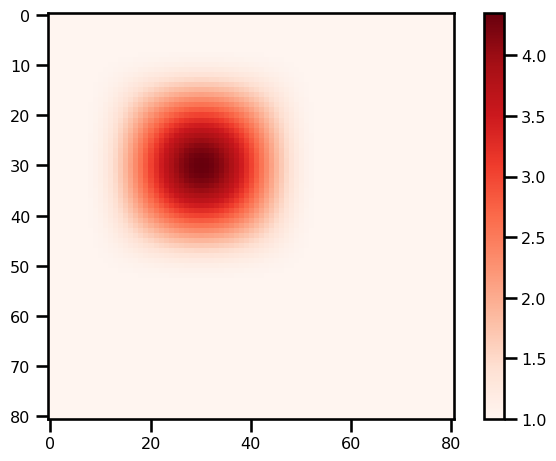

In [9]:
fig, ax = plt.subplots()
pts = ax.imshow(u, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

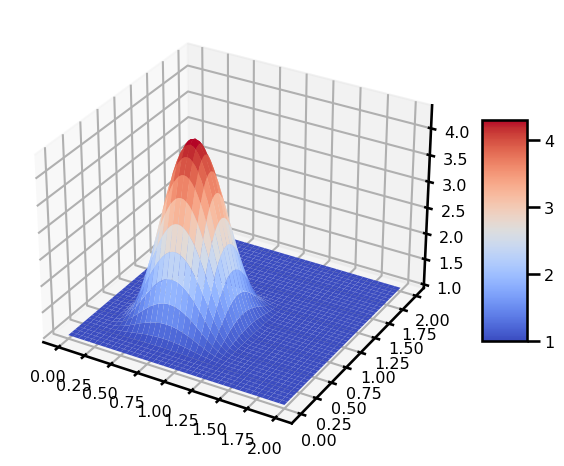

In [11]:
from matplotlib import cm

grid = domain.grid

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(grid[..., 0], grid[..., 1], u, cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()


Steps:

1. Calculate the RHS
2. Apply the Boundary Conditions


### Boundary Conditions

In [12]:
def bc_fn(u: Array) -> Array:
    u = u.at[0, :].set(1.0)
    u = u.at[-1, :].set(1.0)
    u = u.at[:, 0].set(1.0)
    u = u.at[:, -1].set(1.0)
    return u

In [13]:
out = bc_fn(u)

### Dynamical System (RHS)

In [14]:
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

In [18]:
class LinearAdvection2D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, u: Array, args, c=1.0) -> Array:
        u = bc_fn(u)

        # ∂u/∂x - backwards
        du_dx = fdx.difference(
            u,
            axis=0,
            method="backward",
            accuracy=1,
            derivative=1,
            step_size=domain.dx[0],
        )

        # ∂u/∂y - backwards
        du_dy = fdx.difference(
            u,
            axis=1,
            method="backward",
            accuracy=1,
            derivative=1,
            step_size=domain.dx[1],
        )
        # c ∂u/∂x
        return -c * (du_dx + du_dy)

In [19]:
out = LinearAdvection2D.equation_of_motion(0, u, None)

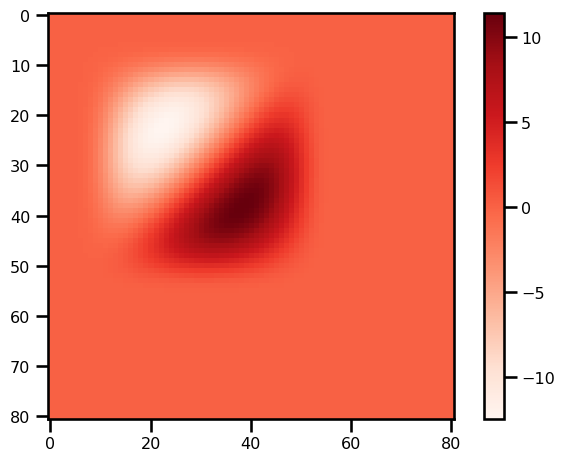

In [20]:
fig, ax = plt.subplots()
pts = ax.imshow(out, cmap="Reds")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

### Time Stepping

In [21]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain
tmin = 0.0
tmax = 0.5
num_save = 50

#### CFL Condition

In [22]:
# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c

In [23]:
# temporal parameters
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=domain.dx[0], c=c, sigma=sigma)

In [25]:
# SPATIAL DISCRETIZATION
# initialize field to be zero
# u_init = init_hat(nx, ny, dx, dy)
u_init = init_smooth(domain)

u = jnp.asarray(u_init)

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = LinearAdvection2D(t_domain=t_domain, saveat=saveat)


# integration
u_sol = dyn_model.integrate(u_init, dt)

In [26]:
u_sol.shape

(50, 81, 81)

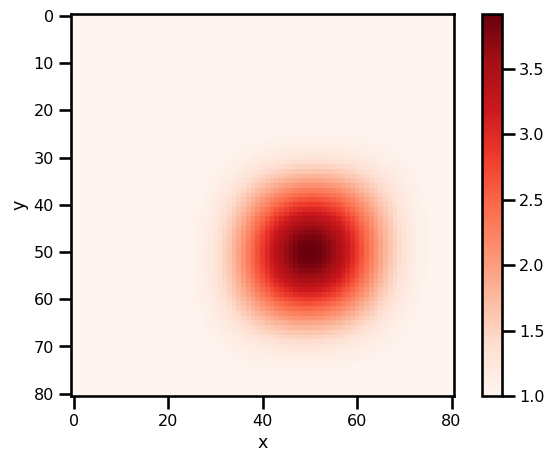

In [27]:
fig, ax = plt.subplots()
pts = ax.imshow(u_sol[-1], cmap="Reds")
ax.set(xlabel="x", ylabel="y")
plt.colorbar(pts)
plt.tight_layout()
plt.show()

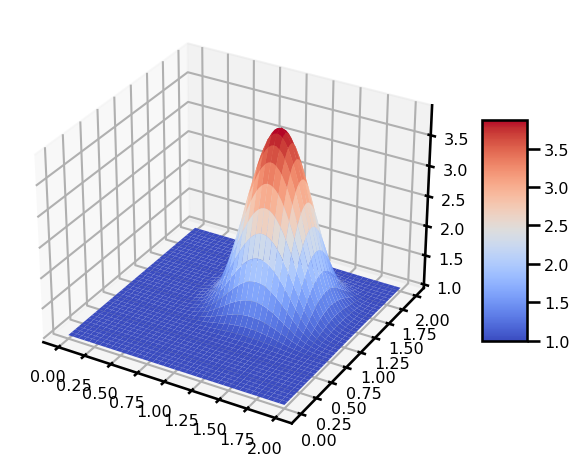

In [28]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(grid[..., 0], grid[..., 1], u_sol[-1], cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()